In [ ]:
import sys
sys.path.append('../')
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import optax
from functools import partial
import matplotlib.pyplot as plt
from windows import initInterval, cosine, norm, unnorm
from matrix_builder import generate_indices
from matrix_builder import elmfbpinn 
from matrix_builder_old import elmfbpinn_old
from networks import phi,phi_dx,phi_dxx, phi_old, phi_dx_old, phi_dxx_old
from utils import display_windows

key = random.PRNGKey(0) 

# Define the exact solution for the damped harmonic oscillator
m = 1
delta = 2
mu = 2 * delta
omega_0 = 80
k = omega_0**2
omega = jnp.sqrt(omega_0**2 - delta**2)

def general_solution(u_0,u_t,t):
    #exp(-delta*t)*(u0*(delta*sin(omega*t) + omega*cos(omega*t)) + u1*sin(omega*t))/omega
    return jnp.exp(-delta*t)*(u_0*(delta*jnp.sin(omega*t) + omega*jnp.cos(omega*t)) + u_t*jnp.sin(omega*t))/omega


def exact_solution_cos(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 2 * A * jnp.exp(-delta * t) * jnp.cos(phi + omega * t)

def exact_solution_sin(t):
    phi = jnp.arctan(-delta / omega)
    A = 1 / (2 * jnp.cos(phi))
    return 1/(omega) *jnp.exp(-delta * t) * jnp.sin(omega * t)

def zero_RHS(t):
    return 0.0 * t

def initWeightBiases(nSubdomains, layer,R=None):
    params_hidden = []  # To store hidden layer parameters
    for i in range(len(layer) - 2):  # Loop through hidden layers only
        key = random.PRNGKey(i)
        w_key_hidden, b_key_hidden, key = random.split(key, 3)
        
        # Calculate weight initialization scale
        if R is None: # He initialization
            v = jnp.sqrt(2. / (layer[i] + layer[i + 1]))
            jax.debug.print("Sampling Range of weights: {v}",v=v)
            W = random.uniform(w_key_hidden, (layer[i], layer[i + 1]), minval=-v, maxval=v)
            b = random.uniform(b_key_hidden, (layer[i + 1],), minval=-v, maxval=v)
            
        else: # Random initialization
            key = random.PRNGKey(0)
            w_key_hidden, b_key_hidden, key = random.split(key, 3)
            W = random.uniform(w_key_hidden, (layer[i], layer[i + 1]), minval=-R, maxval=R)
            b = random.uniform(b_key_hidden, (layer[i + 1],), minval=-R, maxval=R)
        
        params_hidden.append((W, b))
    
    # Output layer (unique weights and biases for each subdomain)
    key = random.PRNGKey(len(layer) - 2)  # Ensure a new key for the output layer
    w_key, b_key, key = random.split(key, 3)
    
    if R is None: 
        v = jnp.sqrt(2. / (layer[-2] + layer[-1]))
        #jax.debug.print("outer v: {v}",v=v)
        W_out = random.uniform(w_key, (nSubdomains, layer[-2], layer[-1]), minval=-v, maxval=v)
        b_out = random.uniform(b_key, (nSubdomains, layer[-1]), minval=-v, maxval=v)
    
    else:
        key = random.PRNGKey(0)
        w_key_out, b_key_out, key = random.split(key, 3)
        W_out = random.uniform(w_key, (nSubdomains, layer[-2], layer[-1]), minval=-R, maxval=R)
        b_out = random.uniform(b_key, (nSubdomains, layer[-1]), minval=-R, maxval=R)
    
    params_out = (W_out, b_out)
    
    return params_hidden, params_out, w_key_hidden,b_key_hidden

def initInterval(nSubdomains, xmin, xmax, width=1.9, verbose=False):
    sd = (xmax - xmin) / nSubdomains
    xc = jnp.linspace(xmin, xmax, nSubdomains)
    xmins = xc - width*sd
    xmaxs = xc + width*sd
    if verbose:
        display_windows(xmins, xmaxs)
    return jnp.stack([xmins, xmaxs], axis=-1)

# Normalization and denormalization functions
def norm(mu, sd, x):
    return (x - mu) / sd

def unnorm(mu, sd, x):
    return x * sd + mu

# Forward pass through the neural network
def forward(x, params_hidden, params_outer_layer,sigma):
    for weight, bias in params_hidden:
        x = sigma(jnp.dot(x, weight) + bias)
        
    final_weight, final_bias = params_outer_layer
    return jnp.dot(x, final_weight) + final_bias

# Function to be vmapped across the x points and subdomains
def inner(params_hidden, params_outer_layer, ranges, x, sigma):
    xmin, xmax = ranges
    mu = (xmin + xmax) / 2
    sd = (xmax - xmin) / 2

    w = window_hat(x, xmin, xmax)
    x = norm(mu, sd, x)
    x = forward(x, params_hidden, params_outer_layer, sigma)
    x = unnorm(0, 1, x)

    return w * x

def cosine(xmin,xmax, x):
    mu, sd = (xmin+xmax)/2, (xmax-xmin)/2
    ws = ((1+jnp.cos(jnp.pi*(x-mu)/sd))/2)**2
    ws = jnp.heaviside(x-xmin,1)*jnp.heaviside(xmax-x,1)*ws
    w = jnp.prod(ws, axis=0, keepdims=True)
    return w

# Partition of Unity window function
def window_hat(x, xmin, xmax):
    condition = jnp.logical_and(x >= xmin, x <= xmax)
    mu = (xmin + xmax) / 2.0
    sd = (xmax - xmin) / 2.0
    return jnp.where(condition, (1 + jnp.cos(jnp.pi * (x - mu) / sd)) ** 2, 0)

def model(params, ranges, x, sigma):
    us = jax.vmap(
        jax.vmap(inner, in_axes=(None, None, None, 0, None)),  # Inner vmap for each x
        in_axes=(None, 0, 0, None, None)  # Outer vmap for each subdomain j
    )(params[0], params[1], ranges, x, sigma)

    return jnp.sum(us, axis=0)

#supervised loss
def single_loss_fn(params, ranges, x, y,sigma):
    # Get the model predictions
    u = model(params, ranges, x,sigma)
    
    # Compute the mean squared error loss
    return jnp.mean((u - y) ** 2)

def sum_losses(params, ranges, x, y, sigma):
    loss_fn = lambda y_single: single_loss_fn(params, ranges, x, y_single, sigma)
    losses = jax.vmap(loss_fn)(y)  # Apply single_loss_fn to each y in parallel
    return jnp.sum(losses)


# Training step
#from jax import jit
@partial(jax.jit, static_argnums=(5,6))
def train_step(params, ranges, opt_state, x, y, optimizer,sigma):
    # Compute the gradient of the loss function
    loss, grads = jax.value_and_grad(sum_losses, has_aux=False)(params, ranges, x, y,sigma)

    # Apply the updates to the parameters
    updates, opt_state = optimizer.update(grads, opt_state)

    # Apply the updates to the entire params
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss



In [79]:
def basis_pretrain(layer_sizes, J, xmin, xmax, nSamples, epochs, epoch_print, learning_rate, sigma, harm_u_exact=None,R=None):
    # Initialize random key and parameters
    key = random.PRNGKey(0)
    
    # Initialize the weights and biases for the hidden and output layers
    params_hidden, params_out, w_key,b_key = initWeightBiases(J, layer_sizes,R)
    params = (params_hidden, params_out)
    
    # Initialize the subdomains
    ranges = initInterval(J, xmin, xmax,width=1.9,verbose=False)
    
    # Create training data
    x_train = jnp.linspace(xmin, xmax, nSamples).reshape(-1, 1)
    #y_train = harm_u_exact(x_train)
    y_cos = exact_solution_cos(x_train) #Y number of these
    y_sin= exact_solution_sin(x_train) #Y number of these

    y_train = jnp.stack([y_cos,y_sin],axis=0)
    
    # Initialize optimizer (Adam optimizer)
    key, subkey = random.split(key)
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    # Training loop
    for epoch in range(epochs):
        # Perform one training step
        # print(f"before params: {params}")
        params, opt_state, loss = train_step(params, ranges, opt_state, x_train, y_train, optimizer, sigma)
        #print(f"after params: {params}")
        # Print loss every 1000 epochs
        if epoch % epoch_print == 0:
            print(f"Epoch {epoch}, Loss: {loss:.9f}")
    
    # Return the trained parameters, optimizer state, and final loss
    return params,ranges, opt_state, key, w_key,b_key, y_train

In [90]:
layer_sizes = [1, 32,32, 1]
J = 20
R = None
xmin, xmax = 0, 1
nSamples = 300
epochs = 50000
epoch_print = epochs/10
learning_rate = 1e-3

sin_params, sin_ranges, sin_opt_state,key, w_key,b_key, y_train= basis_pretrain(layer_sizes, J, xmin, xmax,nSamples, epochs,epoch_print, learning_rate, jnp.sin, harm_u_exact = exact_solution_cos,R=R)

Sampling Range of weights: 0.24618297815322876
Sampling Range of weights: 0.1767766922712326
Epoch 0, Loss: 1.386304855
Epoch 5000, Loss: 0.062125780
Epoch 10000, Loss: 0.062107630
Epoch 15000, Loss: 0.062091637
Epoch 20000, Loss: 0.062087506
Epoch 25000, Loss: 0.062087506
Epoch 30000, Loss: 0.062083140
Epoch 35000, Loss: 0.062087994
Epoch 40000, Loss: 0.062115610
Epoch 45000, Loss: 0.062082507


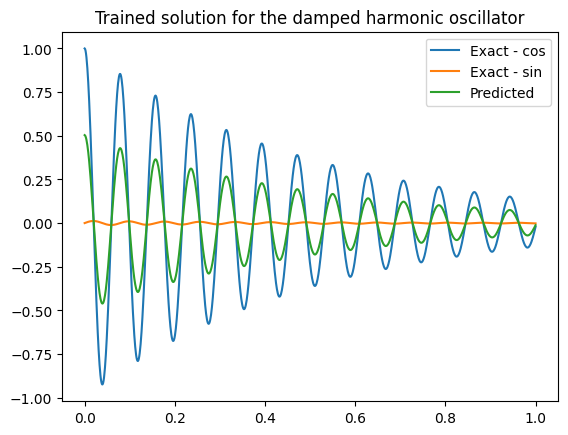

In [92]:
#Plot the trained solution
x = jnp.linspace(xmin, xmax, 1000).reshape(-1, 1)
y = exact_solution_cos(x)
y_sin = exact_solution_sin(x)
y_pred = model(sin_params, sin_ranges, x, jnp.sin)
plt.plot(x, y, label="Exact - cos")
plt.plot(x, y_sin, label="Exact - sin")
plt.plot(x, y_pred, label="Predicted")
plt.title("Trained solution for the damped harmonic oscillator")
plt.legend()
plt.show()

In [66]:
# import numpy as np

# # Function to evaluate activations of the hidden units
# def get_hidden_activations(x_vals, params,sigma):
#     activations = []
#     x = x_vals
#     for weight, bias in params[0]:  # Iterate over all hidden layers
#         x = sigma(jnp.dot(x, weight) + bias)
#         activations.append(x)
    
#     plt.figure(figsize=(15, 10))
#     for i, activation in enumerate(activations):
#         plt.plot(x_vals, activation, label=f'Hidden Unit {i+1}')
        
#     plt.xlabel('Input x')
#     plt.ylabel('Activation')
#     plt.title(f'Activation of Hidden Units: {sigma.__name__}')
#     plt.grid()
#     plt.show()
#     return activations

In [67]:
# # Generate a set of x values to evaluate the activations
# x_vals = jnp.linspace(0, 1, nSamples).reshape(-1, 1)
# # Get the activations for the hidden units
# hidden_activations = get_hidden_activations(x_vals, sin_params,jnp.sin)


In [68]:
# hidden_activations = get_hidden_activations(x_vals, sin_params,jnp.tanh)# 

### Old Function test

Creating M_ode...
M_ode created in 0.14 seconds.
Creating B_train...
B_train created in 0.30 seconds.
Training loss: 3.90e-02
Full training loss: 4.03e-02
Time taken for solver: 0.0098 seconds
Creating M_sol...
M_sol created in 0.17 seconds.
Test Loss Value: 2.73e-02


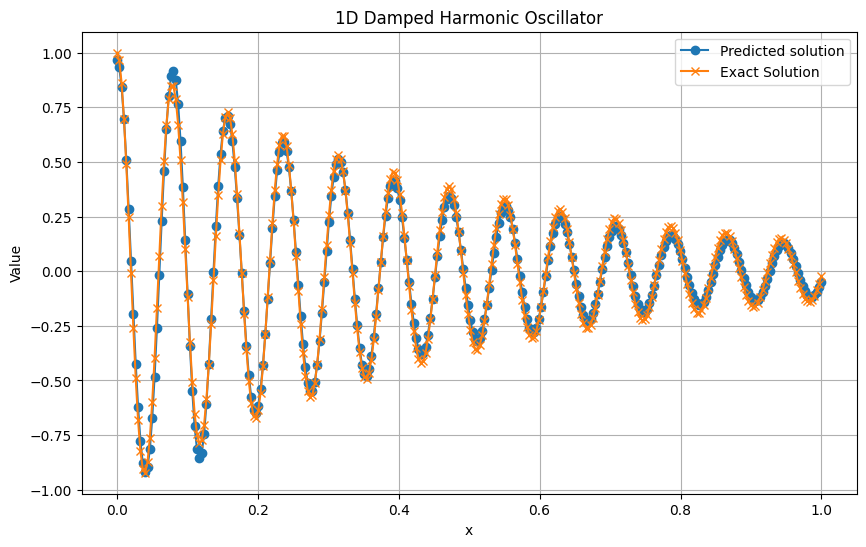

Condition number of M_ode_sparse: 1.73e+10
Condition number of M_sol_sparse: 8.61e+10
Condition Number of LHS: 2.29e+12
Total time taken: 1.05 seconds.


In [69]:
RHS_func = zero_RHS
u_func = exact_solution_cos
n_train = 150
n_test = 300
J=20
C=32
R=0.24
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
old_results = elmfbpinn_old(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    C,
    R,
    xmin,
    xmax,
    width,
    sigma,
    title,
    w_key,
    b_key,
    lmda=1,
    plot_window=False,
    debug=False
)

### Sin params - Initialised, untrained

Creating M_ode...
M_ode created in 0.10 seconds.
Creating B_train...
Training loss: 3.90e-02
Full training loss: 4.03e-02
Time taken for solver: 0.0043 seconds
Creating M_sol...
M_sol created in 0.11 seconds.
Test Loss Value: 2.73e-02
x_test shape: (300, 1)
u_test shape: (300,)
u_exact shape: (300,)


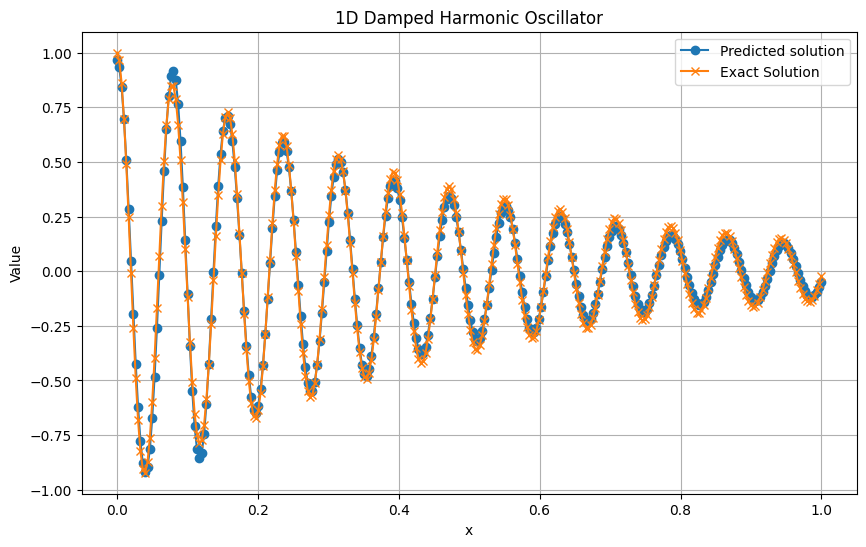

Condition number of M_ode_sparse: 1.73e+10
Condition number of M_sol_sparse: 8.61e+10
Condition number of LHS: 2.29e+12
Total time taken: 0.49 seconds.


In [70]:
RHS_func = zero_RHS
u_func = exact_solution_cos
n_train = 150
n_test = 300
J=20
C=32
R=0.24
params_hidden, params_out, w_key_hidden,b_key_hidden = initWeightBiases(J,[1,C,1],R)
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"

untrained_results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    sin_ranges,
    xmin,
    xmax,
    width,
    sigma,
    title,
    params_hidden,
    lmda=1,
    plot_window=False,
    debug=False,
)

### Sin params - Trained

In [71]:
params_hidden, params_out = sin_params
hidden_weights = params_hidden[0][0]
trained_a_weights = params_out

hidden_weights

Array([[ 0.15201424, -0.21508913, -0.43970564, -0.08357027, -0.2012013 ,
         0.12780377,  0.04064082, -0.13834101,  0.37223053, -0.19770715,
        -0.19140762,  0.02333981, -0.48107046, -0.3572476 ,  0.06123863,
         0.14106724,  0.18177758, -0.48009124,  0.47364983,  0.05414273,
        -0.1317793 , -0.22107293,  0.14896679,  0.202461  ,  0.17375728,
        -0.05423091,  0.11240547,  0.95514435, -0.1824708 ,  0.02228697,
         0.202828  ,  0.07614104]], dtype=float32)

In [72]:
trained_a_weights = params_out[0]
trained_a_biases = params_out[1]


Creating M_ode...
M_ode created in 0.07 seconds.
Creating B_train...
Training loss: 1.19e-01
Full training loss: 1.19e-01
Time taken for solver: 0.0050 seconds
Creating M_sol...
M_sol created in 0.05 seconds.
Test Loss Value: 2.64e-01
x_test shape: (300, 1)
u_test shape: (300,)
u_exact shape: (300,)


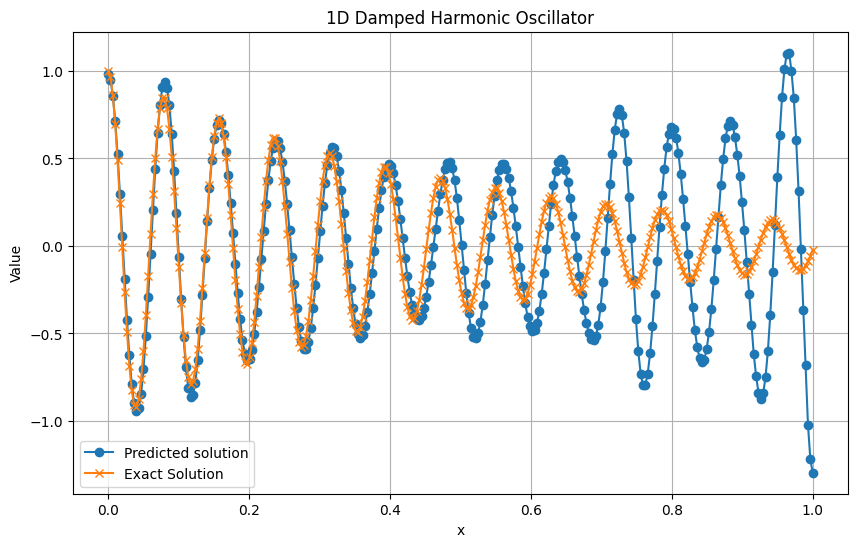

Condition number of M_ode_sparse: 1.99e+10
Condition number of M_sol_sparse: 2.67e+11
Condition number of LHS: 2.04e+13
Total time taken: 0.40 seconds.


In [73]:
params_hidden, params_out = sin_params
hidden_weights = params_hidden[0][0]
a_pre_trained = params_out[0]
hidden_biases = params_hidden[0][1]

RHS_func = zero_RHS
u_func = exact_solution_cos
n_train = 150
n_test = 300
J=20
width = 1.9
sigma = jnp.sin
xmin,xmax= 0,1
title = "1D Damped Harmonic Oscillator"
trained_results = elmfbpinn(
    RHS_func,
    u_func,
    n_train,
    n_test,
    J,
    sin_ranges,
    xmin,
    xmax,
    width,
    sigma,
    title,
    params_hidden,
    lmda=1,
    plot_window=False,
    debug=False,
)

In [75]:
lsq, Ms, B, a, u, loss, x, f, lhs_condition, xmins, xmaxs, total_elapsed_time, rows, columns = trained_results
M_ode_sparse, B_ode_scaled, lmda, exact_solution, g_train = lsq

In [ ]:
import scipy.sparse as sp
u_train_pretrained = M_ode_sparse@a_pre_trained.reshape(640,)
B_csc = sp.csc_matrix(B_ode_scaled)

jnp.linalg.norm(M_ode_sparse @ a_pre_trained.reshape(640,) - f, ord=2) ** 2 + lmda * jnp.linalg.norm(B_csc @ a_pre_trained.reshape(640,) - g_train, ord=2) ** 2

Array(6.845705, dtype=float32)

In [77]:
jnp.linalg.norm(M_ode_sparse @ a - f, ord=2) ** 2 + lmda * jnp.linalg.norm(B_csc @ a - g_train, ord=2) ** 2

Array(0.11919414, dtype=float32)

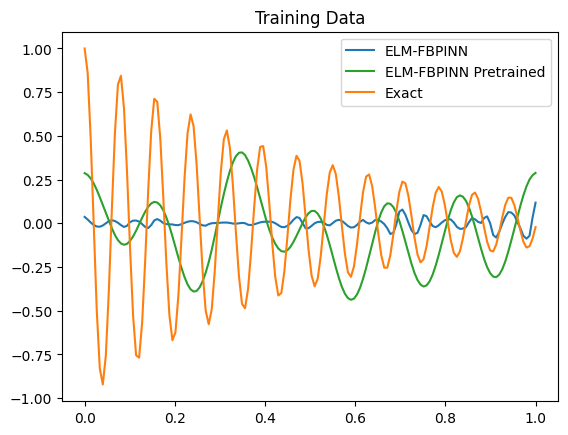

In [78]:
u_train_elm = M_ode_sparse@a
u_train_pretrained = M_ode_sparse@a_pre_trained.reshape(640,)
x_train = x[0]
u_exact_train = exact_solution_cos(x_train)

colors = plt.cm.tab10.colors

plt.plot(x_train, u_train_elm, label="ELM-FBPINN", color=colors[0])  # blue
plt.plot(x_train, u_train_pretrained, label="ELM-FBPINN Pretrained", color=colors[2])  # green
plt.plot(x_train, u_exact_train, label="Exact", color=colors[1])  # orange
plt.title("Training Data")
plt.legend()
plt.show()